In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

In [2]:
from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.analysis import parcoords
from ema_workbench import Policy



In [3]:
np.random.seed(0)

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [5]:
# with open('data/moro_results7.pickle', 'rb') as filehandler:
#         results4 = pickle.load(filehandler)

# archive, convergence= results4

In [ ]:
import pickle

class MyCustomUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == "__main__":
            module = "program"
        return super().find_class(module, name)

with open('data/moro_results7.pickle', 'rb') as f:
    unpickler = MyCustomUnpickler(f)
    results = unpickler.load()

archive, convergence = results

In [6]:
used_problem_formulation = 3

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [7]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [2]:
pol_list = []
#pol_list.append(create_policy({}, name="Zero"))
location = '2'

pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, f"{location}_RfR 0": 0, "EWS_DaysToThreat": 4},
                            name=f"Dike_{10}dm_RfR_{location}0_EWS_4d"))

pol_list.append(create_policy({"A.3_DikeIncrease 0": 0, f"{location}_RfR 0": 1, "EWS_DaysToThreat": 4},
                            name=f"Dike_{0}dm_RfR_{location}1_EWS_4d"))
                            
pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, f"{location}_RfR 0": 1, "EWS_DaysToThreat": 4},
                            name=f"Dike_{10}dm_RfR_{location}1_EWS_4d"))                           

NameError: name 'create_policy' is not defined

In [9]:
policies = archive.iloc[:,:-3]

In [10]:

policies_to_evaluate = []

for i, policy in policies.iterrows():
    pol_list.append(Policy(str(i), **policy.to_dict()))

In [11]:
n_scenarios = 1000
model, _ = get_model_for_problem_formulation(3)
use_pickle6 = False
if use_pickle6:
    with open('data/opt_analysis.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=8) as evaluator:
        results = evaluator.perform_experiments(n_scenarios,
                                                pol_list)
      # Save results in Pickle file
    with open("data/opt_analysis.pickle","wb") as filehandler:
        pickle.dump(results, filehandler)                                           

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
100%|██████████████████████████████████████| 4000/4000 [07:12<00:00,  9.26it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [102]:
experiments, outcomes = results



policies = experiments['policy']



data = pd.DataFrame.from_dict(outcomes)
a = data.columns[data.columns.str.contains('Costs')]
data['Total Costs'] = data[a].sum(axis=1)
a = data.columns[data.columns.str.contains('Deaths')]
data['Total Deaths'] = data[a].sum(axis=1)

data['policy'] = policies

# sns_plot = sns.pairplot(data, hue='policy',  vars=outcomes.keys(), )
# sns_plot.savefig('pairplot_optimize.png')
# plt.show()

In [103]:
data.rename({'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D'},axis=1, inplace=True)

In [104]:
data

,1.C,1.D,2.C,2.D,3.C,3.D,4.C,4.D,5.C,5.D,RfR Total Costs,Expected Evacuation Costs,Total Costs,Total Deaths,policy
0,2.418879e+09,0.226123,1.248427e+08,0.016176,4.421502e+07,0.0,0.000000e+00,0.000000,7.200497e+08,0.086065,0.000000e+00,117766.841532,3.308104e+09,0.328364,Policy_Dike_10dm_RfR_20_EWS_4d
1,0.000000e+00,0.000000,2.193098e+08,0.021350,4.421502e+07,0.0,4.737480e+07,0.002257,0.000000e+00,0.000000,0.000000e+00,16175.451822,3.109158e+08,0.023606,Policy_Dike_10dm_RfR_20_EWS_4d
2,0.000000e+00,0.000000,1.960698e+08,0.027644,4.421502e+07,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,16448.007231,2.403013e+08,0.027644,Policy_Dike_10dm_RfR_20_EWS_4d
3,2.776733e+09,0.178728,0.000000e+00,0.000000,4.421502e+07,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,28749.747111,2.820977e+09,0.178728,Policy_Dike_10dm_RfR_20_EWS_4d
4,1.028650e+08,0.012990,4.355512e+07,0.007288,4.421502e+07,0.0,3.234093e+06,0.000292,8.602410e+07,0.013791,0.000000e+00,16724.157148,2.799101e+08,0.034361,Policy_Dike_10dm_RfR_20_EWS_4d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4.144291e+08,0.000000,4.336808e+08,0.000000,1.926665e+08,0.0,8.882453e+07,0.000000,2.535040e+08,0.000000,2.131200e+09,0.000000,3.514305e+09,0.000000,0
3996,4.144291e+08,0.000000,4.336808e+08,0.000000,1.926665e+08,0.0,8.882453e+07,0.000000,2.535040e+08,0.000000,2.131200e+09,0.000000,3.514305e+09,0.000000,0
3997,4.144291e+08,0.000000,4.336808e+08,0.000000,1.926665e+08,0.0,8.882453e+07,0.000000,2.535040e+08,0.000000,2.131200e+09,0.000000,3.514305e+09,0.000000,0
3998,4.144291e+08,0.000000,4.336808e+08,0.000000,1.926665e+08,0.0,8.882453e+07,0.000000,2.535040e+08,0.000000,2.131200e+09,0.000000,3.514305e+09,0.000000,0


In [105]:
# data[['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
#        '5.D', 'RfR Total Costs', 'Expected Evacuation Costs']] = data[['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
#        '5.D', 'RfR Total Costs', 'Expected Evacuation Costs']].astype('int64')

In [106]:
pol_list = data['policy'].unique()

count=0
for i in pol_list:
    
    data.loc[data.policy== i, 'policy'] = count
    count+=1

In [108]:
limits = parcoords.get_limits(data.iloc[:,:-1])
dimensionlist = []

for column in limits:
    lower=0
    upper=limits[column].iloc[1]
    #print(upper)
    if upper>0:
        dimensionlist.append(dict(range = [lower,upper],
                label = column, values = data[column].values, tickformat = "~g"))
    else:
        dimensionlist.append(dict(range = [lower,0.1],
                label = column, values = data[column].values, tickformat = "~g"))


In [109]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure(data=
    go.Parcoords(line = dict(color = data['policy'], showscale=True),
                   dimensions= dimensionlist
                             ))
fig.show()

 On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow range of uncertainty about the outcomes. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation should be different.

In [13]:
#function for signal to nois ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
    

In [110]:
experiments, outcomes = results

#first iterates over policies then over outcomes to calculate scores
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,0.000000,8.457461e+13,1.121414e-11,5.741908e+00,0.000000e+00,4.841574e+12,4.008120e-13,4.285435e+13,2.698185e-11,0.0,1.959382e+01
Policy_Dike_0dm_RfR_21_EWS_4d,1.455732e+18,0.009269,2.650725e+16,2.999932e-04,1.251643e+17,5.043663e-03,9.111693e+14,2.509013e-06,1.445494e+16,1.685824e-04,0.0,1.646126e+09
Policy_Dike_10dm_RfR_20_EWS_4d,1.455732e+18,0.009269,3.873789e+16,4.516638e-04,3.444050e+14,7.713843e-08,9.927980e+14,2.758654e-06,1.653697e+16,1.942150e-04,0.0,7.823356e+08
Policy_Dike_10dm_RfR_21_EWS_4d,1.455732e+18,0.009269,2.650725e+16,2.999932e-04,9.689261e+13,5.446204e-09,1.078361e+15,3.023810e-06,1.831326e+16,2.150400e-04,0.0,7.323714e+08


In [111]:
scores.columns

Index(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



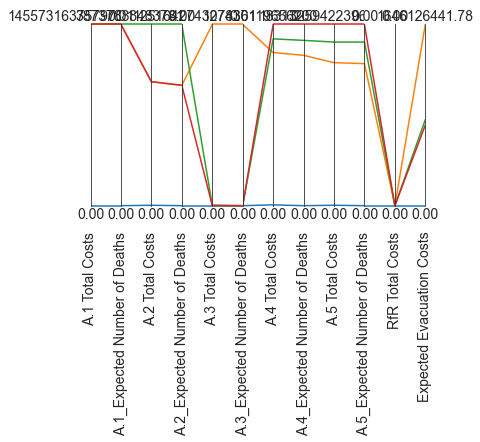

In [112]:
#plots the s/n ratio
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('max_P')
plt.show()

In [113]:
limits

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.0,0.000000e+00
1,1.455732e+18,0.009269,3.873789e+16,0.000452,1.251643e+17,0.005044,1.078361e+15,0.000003,1.831326e+16,0.000215,0.0,1.646126e+09


In [114]:
data.reset_index(inplace=True, drop=True)
data.reset_index(inplace=True)
data.columns.values[0] = "policy"

In [115]:
data.rename({'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D'},axis=1, inplace=True)

In [116]:
data

,policy,1.C,1.D,2.C,2.D,3.C,3.D,4.C,4.D,5.C,5.D,RfR Total Costs,Expected Evacuation Costs
0,0,0.000000e+00,0.000000,8.457461e+13,1.121414e-11,5.741908e+00,0.000000e+00,4.841574e+12,4.008120e-13,4.285435e+13,2.698185e-11,0.0,1.959382e+01
1,1,1.455732e+18,0.009269,2.650725e+16,2.999932e-04,1.251643e+17,5.043663e-03,9.111693e+14,2.509013e-06,1.445494e+16,1.685824e-04,0.0,1.646126e+09
2,2,1.455732e+18,0.009269,3.873789e+16,4.516638e-04,3.444050e+14,7.713843e-08,9.927980e+14,2.758654e-06,1.653697e+16,1.942150e-04,0.0,7.823356e+08
3,3,1.455732e+18,0.009269,2.650725e+16,2.999932e-04,9.689261e+13,5.446204e-09,1.078361e+15,3.023810e-06,1.831326e+16,2.150400e-04,0.0,7.323714e+08


In [117]:
# data['1.C']=data['1.C'].astype('int64')

In [118]:
data2 = data.iloc[::-1,:]

In [119]:
# data[['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
#        '5.D', 'RfR Total Costs', 'Expected Evacuation Costs']] = data[['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
#        '5.D', 'RfR Total Costs', 'Expected Evacuation Costs']].astype('int64')

In [120]:
limits = parcoords.get_limits(data.iloc[:,1::])
dimensionlist = []

for column in limits:
    lower=0
    upper=limits[column].iloc[1]
    if upper>0:
        dimensionlist.append(dict(range = [lower,upper],
                label = column, values = data[column].values, tickformat = "~g"))
    else:
        dimensionlist.append(dict(range = [lower,1],
                label = column, values = data[column].values, tickformat = "~g"))


In [121]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure(data=
    go.Parcoords(line = dict(color = data['policy'],
                   colorscale = [[0,'yellow'],[0.5,'lightseagreen'],[1,'red']], showscale=True),
                   dimensions= dimensionlist
                             ))
fig.show()

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) or reference policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 

In [173]:
#function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

In [174]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    coldict = {'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
       'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
       'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
       'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
       'A.5_Expected Number of Deaths': '5.D', 'RfR Total Costs': 'RfR', 'Expected Evacuation Costs':'Evac Costs'}

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #

    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[coldict.get(outcome.name)] = outcome_regret
    max_regret[coldict.get(outcome.name)] = outcome_regret.max()



C:\Users\hanna\AppData\Local\Temp\ipykernel_2356\3546039520.py:34: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\hanna\AppData\Local\Temp\ipykernel_2356\3546039520.py:34: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\hanna\AppData\Local\Temp\ipykernel_2356\3546039520.py:34: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\hanna\AppData\Local\Temp\ipykernel_2356\3546039520.py:34: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instea

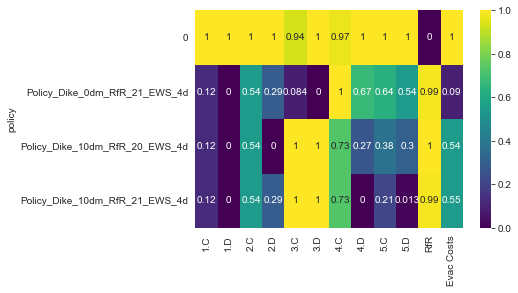

In [175]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations

c:\Users\hanna\Anaconda3\envs\simmaster\lib\site-packages\ema_workbench\analysis\parcoords.py:260: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



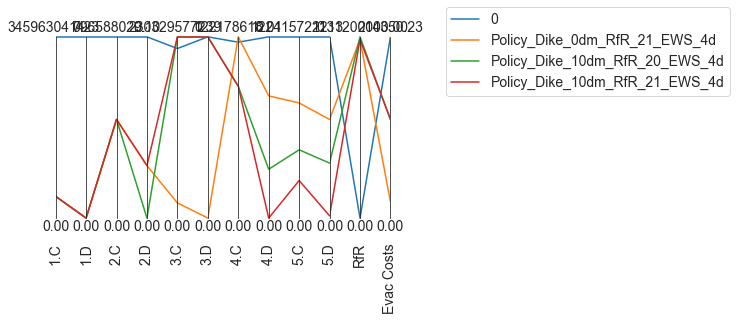

In [176]:

colors = sns.color_palette()

data = max_regret
# data.rename({'A.1 Total Costs': '1.C', 'A.1_Expected Number of Deaths': '1.D',
#        'A.2 Total Costs': '2.C', 'A.2_Expected Number of Deaths': '2.D' , 'A.3 Total Costs': '3.C',
#        'A.3_Expected Number of Deaths': '3.D', 'A.4 Total Costs': '4.C',
#        'A.4_Expected Number of Deaths': '4.D', 'A.5 Total Costs': '5.C',
#        'A.5_Expected Number of Deaths': '5.D'},axis=1, inplace=True)

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['1.C', '1.D', '2.C', '2.D', '3.C', '3.D', '4.C', '4.D', '5.C',
       '5.D', 'RfR', 'Evac Costs']] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

Distribution  of regret

In [177]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

0
Policy_Dike_0dm_RfR_21_EWS_4d
Policy_Dike_10dm_RfR_20_EWS_4d
Policy_Dike_10dm_RfR_21_EWS_4d


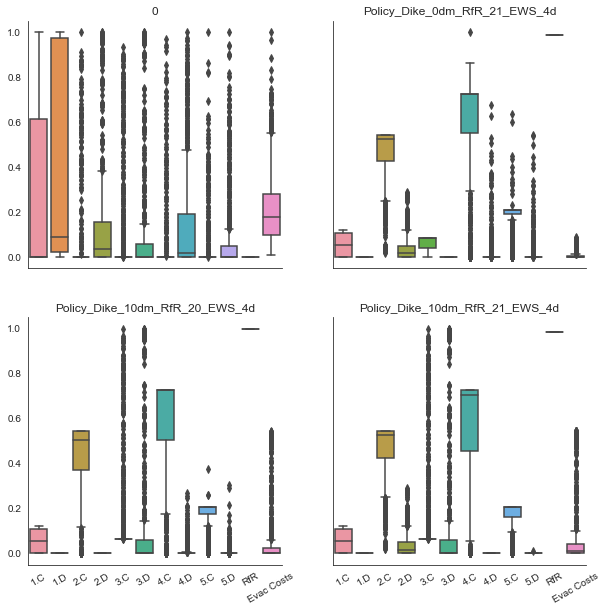

In [184]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0],axes[1,1],]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    print(policy)
    data = pd.DataFrame(regret)
    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

In [181]:
policy_regret.items()

dict_items([('0', {'1.C': scenario
0      2.004450e+09
1      0.000000e+00
2      0.000000e+00
3      2.362304e+09
4      0.000000e+00
           ...     
995    4.303079e+08
996    2.102342e+09
997    0.000000e+00
998    5.238508e+08
999    0.000000e+00
Name: 0, Length: 1000, dtype: float64, '1.D': scenario
0      0.226123
1      0.000000
2      0.000000
3      0.178728
4      0.012990
         ...   
995    0.075336
996    0.221258
997    0.004493
998    0.075235
999    0.000590
Name: 0, Length: 1000, dtype: float64, '2.C': scenario
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
995    0.0
996    0.0
997    0.0
998    0.0
999    0.0
Name: 0, Length: 1000, dtype: float64, '2.D': scenario
0      0.016176
1      0.021350
2      0.027644
3      0.000000
4      0.007288
         ...   
995    0.005639
996    0.000000
997    0.044192
998    0.012977
999    0.006826
Name: 0, Length: 1000, dtype: float64, '3.C': scenario
0      0.000000e+00
1      0.000000e+00
2      3.880